In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, concat
from tqdm import tqdm
sns.set_theme(style='white', context='notebook', font_scale=1.33)

fout = 'n3'

## Section 1: Parameter Recovery

In [2]:
## Locate files.
files = sorted([f for f in os.listdir('stan_results') if fout in f])

## Iteratively load files.
params = []
for f in tqdm(files):
    
    ## Load file.
    npz = np.load(os.path.join('stan_results', f))
    seed = f.replace('2pl_n3_s','').replace('.npz','')
    
    ## Extract parameters.
    dd = dict(param=[], obs=[], pred=[])
    for param in ['theta','beta','alpha']:
        dd['param'] = np.concatenate([dd['param'], np.repeat(param, npz[param].size)])
        dd['obs']   = np.concatenate([dd['obs'], npz[param]])
        dd['pred']  = np.concatenate([dd['pred'], npz[f'{param}_hat']])
        
    ## Convert to DataFrame.
    dd = DataFrame(dd)
    dd.insert(0, 'seed', int(seed))
    
    ## Append. 
    params.append(dd)
    
## Concatenate DataFrames.
params = concat(params)

100%|██████████| 490/490 [00:02<00:00, 166.40it/s]


#### 1.1 Parameter distributions

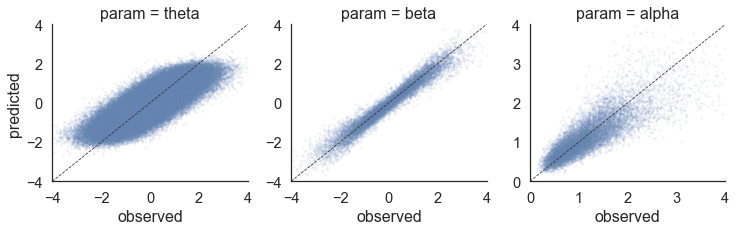

In [3]:
## Initialize canvas.
g = sns.FacetGrid(params, col='param', col_order=['theta','beta','alpha'], sharex=False, sharey=False,
                 aspect=1, height=3.5)
limits = [(-4,4),(-4,4),(0,4)]

## Plot parameters.
g.map(sns.scatterplot, 'obs', 'pred', s=5, alpha=0.1)
for ax, lim in zip(g.axes.flatten(), limits): 
    ax.plot(lim, lim, color='0.2', lw=0.8, linestyle='--')
    ax.set(xlim=lim, ylim=lim)
    
## Add details.
g.set_xlabels('observed')
g.set_ylabels('predicted');

#### 1.2 Recovery metrics

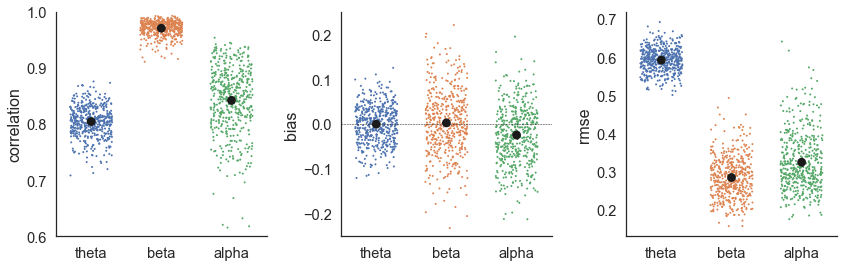

In [4]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))
order = ['theta','beta','alpha']

## Plot correlations.
f = lambda x: x.corr(method='spearman').loc['obs','pred']
corr = params.groupby(['seed','param']).apply(f).reset_index()
sns.stripplot(x='param', y=0, data=corr, order=order, size=2, jitter=0.3, zorder=-1, ax=axes[0])
sns.pointplot(x='param', y=0, data=corr, order=order, marker='s', color='k', join=False, ax=axes[0])
axes[0].set(xlabel='', ylim=(0.6, 1.0), ylabel='correlation')

## Plot bias.
f = lambda x: np.mean(x.pred - x.obs)
bias = params.groupby(['seed','param']).apply(f).reset_index()
sns.stripplot(x='param', y=0, data=bias, order=order, size=2, jitter=0.3, zorder=-1, ax=axes[1])
sns.pointplot(x='param', y=0, data=bias, order=order, marker='s', color='k', join=False, ax=axes[1])
axes[1].set(xlabel='', ylim=(-0.25, 0.25), ylabel='bias')
axes[1].axhline(0, color='k', lw=0.5, linestyle='--', zorder=-1)

## Plot bias.
f = lambda x: np.sqrt(np.mean(np.square(x.pred - x.obs)))
rmse = params.groupby(['seed','param']).apply(f).reset_index()
sns.stripplot(x='param', y=0, data=rmse, order=order, size=2, jitter=0.3, zorder=-1, ax=axes[2])
sns.pointplot(x='param', y=0, data=rmse, order=order, marker='s', color='k', join=False, ax=axes[2])
axes[2].set(xlabel='', ylabel='rmse')

sns.despine()
plt.tight_layout()

#### 1.3 Recovery metric correlations

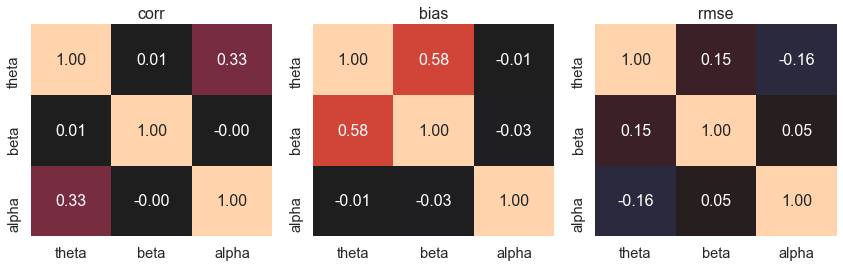

In [5]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))

## Plot correlations.
for ax, df, title in zip(axes, [corr, bias, rmse], ['corr', 'bias', 'rmse']):
    
    ## Plot correlations.
    arr = df.pivot_table(0,'seed','param')[['theta','beta','alpha']].corr()
    sns.heatmap(arr, center=0, vmin=-1, vmax=1, annot=True, fmt='0.2f', cbar=False, ax=ax)
    
    ## Add details.
    ax.set(xlabel='', ylabel='', title=title)
    
plt.tight_layout()

#### 1.4 Recovery by discrimation

100%|██████████| 490/490 [00:00<00:00, 960.56it/s] 


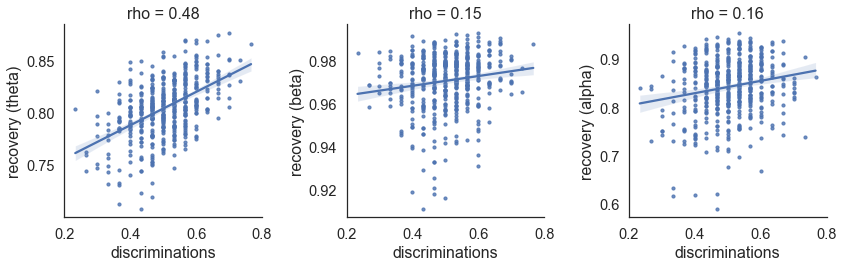

In [6]:
from scipy.stats import spearmanr

## Locate files.
files = sorted([f for f in os.listdir('stan_results') if fout in f])

## Iteratively load files.
masked = []
for f in tqdm(files):
    
    ## Load file.
    npz = np.load(os.path.join('stan_results', f))
    seed = f.replace('2pl_s','').replace('.npz','')
    
    ## Compute fraction of discriminating parameters.
    frac = np.mean(npz['alpha'] >= 1)
    
    ## Append.
    masked.append(frac)
    
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True)
df = corr.pivot_table(0,'seed','param')

## Plot recovery by discrimination.
for ax, param in zip(axes, ['theta','beta','alpha']):
    
    ## Compute correlation.
    rho, _ = spearmanr(masked, df[param])
    
    ## Plot scatterplot.
    sns.regplot(x=masked, y=df[param], scatter_kws=dict(s=10), ax=ax)
    
    ## Add detail.
    ax.set(xticks=np.arange(0.2,0.9,0.2), xlabel='discriminations', ylabel='recovery (%s)' %param, 
           title='rho = %0.2f' %rho)
    
sns.despine()
plt.tight_layout()

## Section 2: Consistency

In [7]:
from scipy.stats import spearmanr
np.random.seed(47404)

## Define functions.
def inv_logit(x):
    return 1 / (1 + np.exp(-x))

## Locate files.
files = sorted([f for f in os.listdir('stan_results') if fout in f])

## Iteratively load files.
approx = []
for f in tqdm(files):
    
    ## Load file.
    npz = np.load(os.path.join('stan_results', f))
    seed = f.replace('2pl_n3_s','').replace('.npz','')
    
    ## Extract parameters.
    theta = npz['theta']; beta = npz['beta']; alpha = npz['alpha']
    
    ## Iteratively.
    for items in ['ground','chosen','random','worst']:
        
        for i, template in enumerate(['uniform','normal']):
            
            ## Extract items.
            indices = npz[items][i]
            
            ## Define metadata.
            J = np.repeat(np.arange(theta.size), indices.size)
            K = np.tile(indices, theta.size)
            
            ## Simulate data.
            mu = inv_logit(alpha[K] * (theta[J] - beta[K]))
            Y = np.random.binomial(1,mu)
            
            ## Compute scores.
            scores = Y.reshape(theta.size, indices.size).sum(axis=1)
            
            ## Compute correlation.
            rho, _ = spearmanr(theta, scores)
            
            ## Append.
            approx.append(dict(seed=int(seed), items=items, template=template, rho=rho))
            
## Convert to DataFrame.
approx = DataFrame(approx)

100%|██████████| 490/490 [00:08<00:00, 58.07it/s]


#### 2.1 Ability consistency

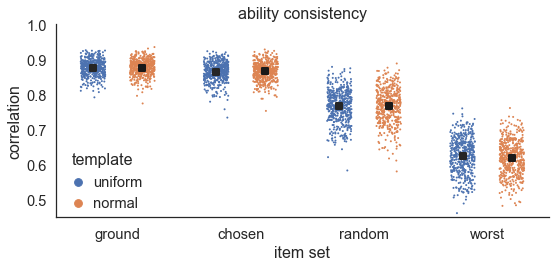

In [8]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot consistency.
sns.stripplot(x='items', y='rho', hue='template', data=approx, dodge=True, size=2, 
              jitter=0.2, zorder=-1, ax=ax)
sns.pointplot(x='items', y='rho', hue='template', data=approx, dodge=0.4, join=False,
              color='k', markers='s',  ax=ax)

## Add detail.
ax.set(xlabel='item set', ylim=(0.45, 1.0), ylabel='correlation', title='ability consistency')

## Clean up legend.
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], loc=3, frameon=False, title='template',
          borderpad=0, handletextpad=0)

sns.despine()
plt.tight_layout()

In [9]:
print(approx.groupby(['template','items']).rho.mean())

template  items 
normal    chosen    0.866131
          ground    0.876815
          random    0.767812
          worst     0.618564
uniform   chosen    0.865109
          ground    0.876331
          random    0.766491
          worst     0.625886
Name: rho, dtype: float64


#### 2.2 Consistency by recovery

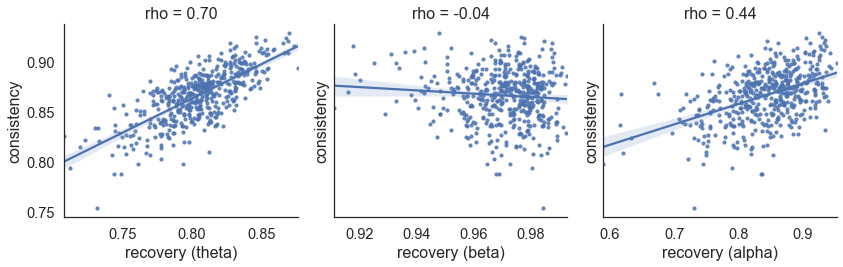

In [10]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4),sharey=True)

## Iteratively plot.
for ax, param in zip(axes, ['theta','beta','alpha']):
    
    ## Compute correlation.
    x = corr.query(f'param == "{param}"')[0].values
    y = approx.query('items=="chosen" and template=="normal"').rho.values
    rho, _ = spearmanr(x, y)
    
    ## Plot scatterplot.
    sns.regplot(x=x, y=y, scatter_kws=dict(s=10), ax=ax)
    
    ## Add detail.
    ax.set(xlabel='recovery (%s)' %param, ylabel='consistency', title='rho = %0.2f' %rho)

sns.despine()
plt.tight_layout()

## Section 3: 

In [11]:
## Locate files.
files = sorted([f for f in os.listdir('stan_results') if fout in f])

## Iteratively load files.
dice = []
for f in tqdm(files):
    
    ## Load file.
    npz = np.load(os.path.join('stan_results', f))
    seed = f.replace('2pl_n3_s','').replace('.npz','')
    
    ## Extract item sets.
    ground = npz['ground']
    chosen = npz['chosen']
    
    ## Compute agreement.
    for x, y, template in zip(ground, chosen, ['uniform','normal']):
        dice.append(dict(seed=int(seed), template=template, dice=np.in1d(y,x).sum()))
        
## Convert to DataFrame
dice = DataFrame(dice)

100%|██████████| 490/490 [00:00<00:00, 665.96it/s]


#### 3.1 Item agreement

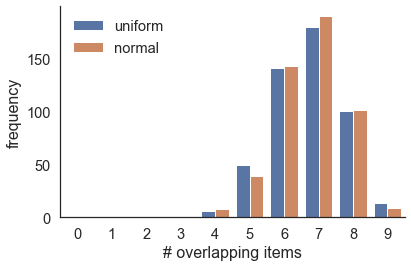

In [12]:
## Intialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot agreement.
sns.countplot(x='dice', hue='template', data=dice, order=np.arange(10), ax=ax)

## Add detail.
ax.set(xlabel='# overlapping items', ylabel='frequency')
ax.legend(loc=2, frameon=False)

sns.despine()
plt.tight_layout()

#### 3.2 Consistency by agreement

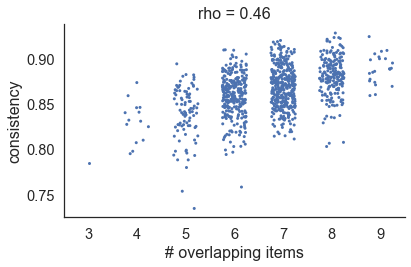

In [13]:
## Intialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Compute correlation.
x = dice.dice.values
y = approx.query('items=="chosen"').rho.values
rho, _ = spearmanr(x, y)

## Plot consistency by agreement.
sns.stripplot(x=x, y=y, size=3, jitter=0.25, color='#4c72b0', ax=ax)

## Add detail.
ax.set(xlabel='# overlapping items', ylabel='consistency', title='rho = %0.2f' %rho)

sns.despine()
plt.tight_layout()

#### 3.3 Recovery by agreement

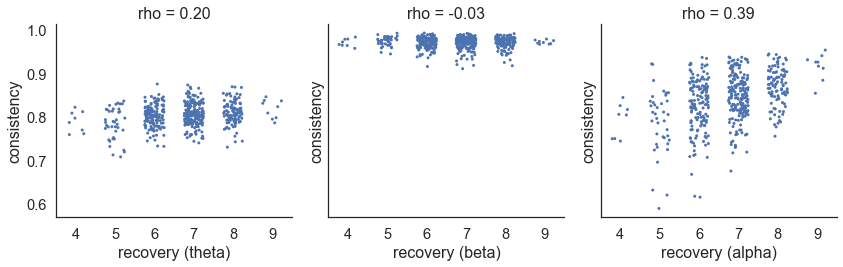

In [14]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4),sharey=True)

## Iteratively plot.
for ax, param in zip(axes, ['theta','beta','alpha']):
    
    ## Compute correlation.
    x = dice.query('template=="normal"').dice.values
    y = corr.query(f'param == "{param}"')[0].values
    rho, _ = spearmanr(x, y)
    
    ## Plot scatterplot.
    sns.stripplot(x=x, y=y, size=3, jitter=0.25, color='#4c72b0', ax=ax)
    
    ## Add detail.
    ax.set(xlabel='recovery (%s)' %param, ylabel='consistency', title='rho = %0.2f' %rho)

sns.despine()
plt.tight_layout()

#### 3.4 Features of chosen items

100%|██████████| 490/490 [00:01<00:00, 274.09it/s]


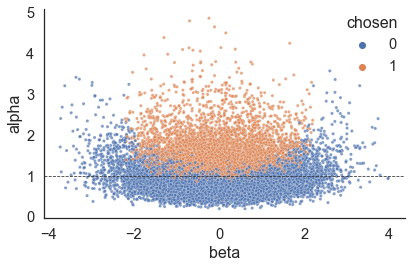

In [15]:
## Locate files.
files = sorted([f for f in os.listdir('stan_results') if fout in f])

## Iteratively load files.
features = []
for f in tqdm(files):
    
    ## Load file.
    npz = np.load(os.path.join('stan_results', f))
    seed = f.replace('2pl_n3_s','').replace('.npz','')
    
    ## Extract parameters.
    df = DataFrame(dict(
        beta   = npz['beta_hat'],
        alpha  = npz['alpha_hat'],
        chosen = np.in1d(np.arange(npz['beta_hat'].size), npz['chosen']).astype(int)
    ))
    features.append(df)
        
## Convert to DataFrame
features = concat(features)

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot features.
sns.scatterplot(x='beta', y='alpha', hue='chosen', data=features, s=10, alpha=0.7, ax=ax)

## Add detail.
ax.legend(loc=1, frameon=False, borderpad=0, title='chosen')
ax.axhline(1, color='0.2', lw=0.8, linestyle='--')

sns.despine()
plt.tight_layout()